#Exploratory Data Analysis

In [ ]:
import sys
!{sys.executable} -m pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 17.1 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

Colab environment detected.


In [ ]:
import pandas as pd
df=pd.read_csv('cleaned_autos.csv')
df.head().T

,0,1,2,3,4
index,3.0,4.0,5.0,6.0,10.0
dateCrawled,3/17/2016 16:54,3/31/2016 17:25,4/4/2016 17:36,4/1/2016 20:48,3/26/2016 19:54
name,GOLF_4_1_4__3TÜRER,Skoda_Fabia_1.4_TDI_PD_Classic,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,Peugeot_206_CC_110_Platinum,Mazda_3_1.6_Sport
seller,privat,privat,privat,privat,privat
offerType,Angebot,Angebot,Angebot,Angebot,Angebot
price,1500,3600,650,2200,2000
abtest,test,test,test,test,control
vehicleType,kleinwagen,kleinwagen,limousine,cabrio,limousine
yearOfRegistration,2001,2008,1995,2004,2004
gearbox,manuell,manuell,manuell,manuell,manuell


In [ ]:
df.dtypes

index                  float64
dateCrawled             object
name                    object
seller                  object
offerType               object
price                    int64
abtest                  object
vehicleType             object
yearOfRegistration       int64
gearbox                 object
powerPS                  int64
model                   object
kilometer                int64
monthOfRegistration      int64
fuelType                object
brand                   object
notRepairedDamage       object
dateCreated             object
nrOfPictures           float64
postalCode             float64
lastSeen                object
dtype: object

In [ ]:
# changing the types of some features to make them useable in our models
df['dateCrawled']=pd.to_datetime(df['dateCrawled'])
df['dateCreated']=pd.to_datetime(df['dateCreated'])
df['lastSeen']=pd.to_datetime(df['lastSeen'])
df['monthOfRegistration']=df['monthOfRegistration'].astype(object)
df['powerPS']=df['powerPS'].astype(object)
df['postalCode']=df['postalCode'].astype(object)
df['yearOfRegistration']=df['yearOfRegistration'].astype(object)

In [ ]:
df.describe()

,index,price,kilometer,nrOfPictures
count,242591.000000,242591.000000,242591.000000,242591.0
mean,185700.421862,6602.067406,123748.634533,0.0
std,107304.364064,6718.246009,39619.515104,0.0
min,3.000000,501.000000,5000.000000,0.0
25%,92555.500000,1850.000000,100000.000000,0.0
50%,185683.000000,4190.000000,150000.000000,0.0
75%,278707.500000,8900.000000,150000.000000,0.0
max,371527.000000,40000.000000,150000.000000,0.0


In [ ]:
df.describe(include=object)

,name,seller,offerType,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
count,242591,242591,242591,242591,242591,242591,242591,242591,242591,242591,242591,242591,242591,242591.0
unique,137136,2,2,2,8,87,2,560,249,13,7,39,2,8065.0
top,BMW_318i,privat,Angebot,test,limousine,2006,manuell,75,golf,3,benzin,volkswagen,nein,10115.0
freq,608,242589,242590,126002,71982,16622,184831,14532,19563,26296,153398,50697,222225,797.0


## Feature Engineering

In [ ]:
# remove 3 columns seller and offertype and nrOfPictures because they only have 1 unique values:
df=df.drop(columns=['index','seller','offerType','nrOfPictures'])

In [ ]:
# change the language of some values from German to English for better understanding
df['gearbox'] = df['gearbox'].apply(lambda g: 'Manual' if g == 'manuell' else 'Automatic')
df['notRepairedDamage'] = df['notRepairedDamage'].apply(lambda g: 'Yes' if g == 'ja' else 'No' if g =='nein' else 'NaN')
df['fuelType'].unique()
df.loc[df['fuelType'] == 'benzin', 'fuelType'] = 'Petrol'

In [ ]:
# define 3 new columns. age of the 'Age_of_car' for better understanding the column of 'yearOfRegistration'
# 'interval_first_lastseen' to analyze if the interval between first and last seen of an ad could affect the price of a car
# 'interval_creation_firstseen' to analyze how an ad was attractive and if the interval between creation and first seen of an ad could affect the price of a car
from datetime import datetime
df['Age_of_car']=2016-df['yearOfRegistration']
df['interval_first_lastseen']=df['lastSeen']-df['dateCrawled']
df['interval_creation_firstseen']=df['dateCrawled']-df['dateCreated']
df.head()

,dateCrawled,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen,Age_of_car,interval_first_lastseen,interval_creation_firstseen
0,2016-03-17 16:54:00,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,Manual,75,golf,150000,6,Petrol,volkswagen,No,2016-03-17,91074.0,2016-03-17 17:40:00,15,0 days 00:46:00,0 days 16:54:00
1,2016-03-31 17:25:00,Skoda_Fabia_1.4_TDI_PD_Classic,3600,test,kleinwagen,2008,Manual,69,fabia,90000,7,diesel,skoda,No,2016-03-31,60437.0,2016-04-06 10:17:00,8,5 days 16:52:00,0 days 17:25:00
2,2016-04-04 17:36:00,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,Manual,102,3er,150000,10,Petrol,bmw,Yes,2016-04-04,33775.0,2016-04-06 19:17:00,21,2 days 01:41:00,0 days 17:36:00
3,2016-04-01 20:48:00,Peugeot_206_CC_110_Platinum,2200,test,cabrio,2004,Manual,109,2_reihe,150000,8,Petrol,peugeot,No,2016-04-01,67112.0,2016-04-05 18:18:00,12,3 days 21:30:00,0 days 20:48:00
4,2016-03-26 19:54:00,Mazda_3_1.6_Sport,2000,control,limousine,2004,Manual,105,3_reihe,150000,12,Petrol,mazda,No,2016-03-26,96224.0,2016-04-06 10:45:00,12,10 days 14:51:00,0 days 19:54:00


In [ ]:
# for using the new features in our models we should change the type of them from delta to seconds
df['num_interval_first_lastseen']=df['interval_first_lastseen'].dt.total_seconds()
df['num_interval_creation_firstseen']=df['interval_creation_firstseen'].dt.total_seconds()
df['Age_of_car']=df['Age_of_car'].astype(int)
df['powerPS']=df['powerPS'].astype(int)
df['monthOfRegistration']=df['monthOfRegistration'].astype(int)

In [ ]:
# encoding non_ordinal_features that the order do not matter for them
non_ordinal_cat_cols=['model','fuelType','brand','vehicleType']
def levels2index(levels):
    dct = {}
    for i in range(len(levels)):
        dct[levels[i]] = i
    return dct

for col in non_ordinal_cat_cols:
    level_substitution = levels2index(df[col].unique())
    df[col].replace(level_substitution, inplace=True)

## Visualizations

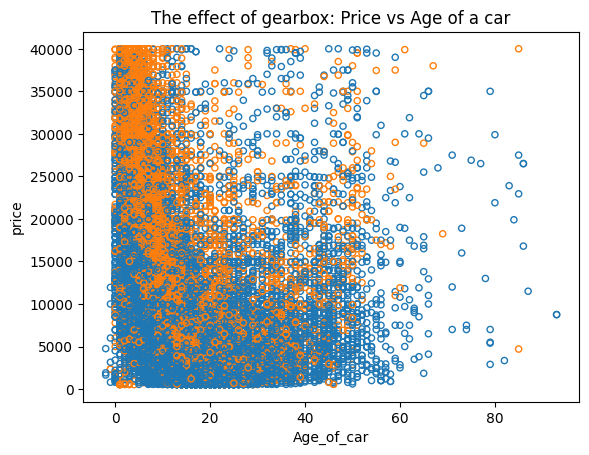

In [ ]:
import matplotlib.pyplot as plt
df.plot.scatter(x='Age_of_car', y='price',color='none',edgecolor=['C0' if c == 'Manual' else 'C1' for c in df.gearbox])
plt.title('The effect of gearbox: Price vs Age of a car')
plt.show()

<ipython-input-14-9f4873a737f2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


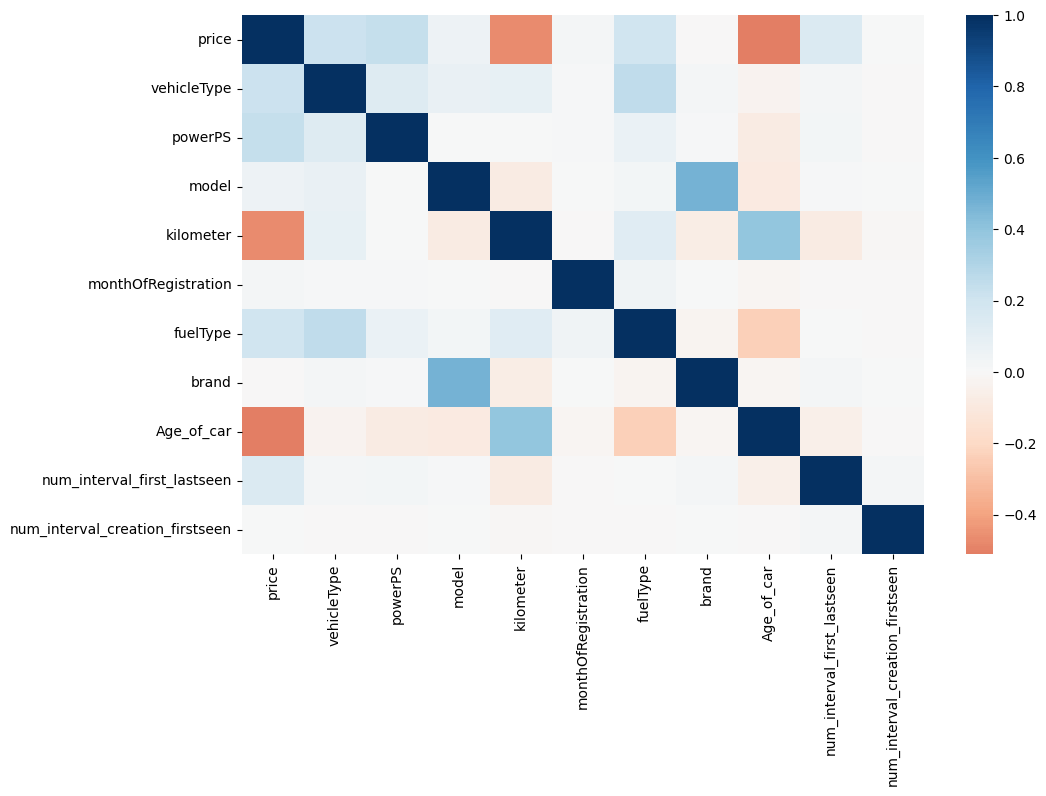

In [ ]:
import seaborn as sns
corr = df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=False, fmt=".1f", cmap="RdBu", center=0, ax=ax)

plt.show()

# Linear regression model with all features

In [ ]:
predictors = ['abtest', 'vehicleType','gearbox', 'powerPS', 'model', 'kilometer',
       'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'Age_of_car',
       'num_interval_first_lastseen', 'num_interval_creation_firstseen']
outcome = 'price'

# partition data
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(valid_y, car_lm.predict(valid_X))

intercept  18428.747359920304
                          Predictor  coefficient
0                       vehicleType   620.653045
1                           powerPS     6.081895
2                             model     1.030184
3                         kilometer    -0.061786
4               monthOfRegistration     0.945415
5                          fuelType  1025.678817
6                             brand   -49.394937
7                        Age_of_car  -313.603072
8       num_interval_first_lastseen     0.000683
9   num_interval_creation_firstseen    -0.000055
10                      abtest_test    -9.737873
11                   gearbox_Manual -3670.500004
12            notRepairedDamage_Yes -2306.667501

Regression statistics

                      Mean Error (ME) : 12.4966
       Root Mean Squared Error (RMSE) : 4690.1838
            Mean Absolute Error (MAE) : 3132.4241
          Mean Percentage Error (MPE) : -45.3274
Mean Absolute Percentage Error (MAPE) : 88.2794


In [ ]:
pred_y = car_lm.predict(valid_X)

print('adjusted r2 : ', adjusted_r2_score(valid_y, pred_y, car_lm))
print('AIC : ', AIC_score(valid_y, pred_y, car_lm))
print('BIC : ', BIC_score(valid_y, pred_y, car_lm))

adjusted r2 :  0.5105029208854013
AIC :  1915960.6644306171
BIC :  1916102.907145038


In [ ]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

           Predicted  Actual      Residual
110297   6390.702001    4700  -1690.702001
213318  15679.912358   14999   -680.912358
178912  16418.250415   34000  17581.749585
201044  16253.818572   17999   1745.181428
107405   9024.061449    7900  -1124.061449
156       644.611189     800    155.388811
33589     900.621580    1390    489.378420
94773   16046.219139   27490  11443.780861
66570   13896.903676   23999  10102.096324
24234    1353.432855    1100   -253.432855
118480   6457.476650     850  -5607.476650
194800   6385.368253    4380  -2005.368253
2494     4631.728241    7400   2768.271759
43654    6752.682073   15000   8247.317927
216253   3100.737028    2250   -850.737028
222077  10378.314837   21500  11121.685163
140963  16981.680465   24599   7617.319535
136843   3401.794482    7500   4098.205518
169031  13530.165637   10600  -2930.165637
48022    1451.995669     890   -561.995669

Regression statistics

                      Mean Error (ME) : 12.4966
       Root Mean Squared 

# Features Selection

In [ ]:
# it is obvious that monthOfRegistration, num_interval_creation_firstseen, abtest have the lower affect on the performance of our models
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)

    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj           AIC  Age_of_car  abtest_test  brand  fuelType  gearbox_Manual  \
0    1  0.262295  2.934609e+06        True        False  False     False           False   
1    2  0.347308  2.916788e+06        True        False  False     False           False   
2    3  0.428223  2.897524e+06        True        False  False     False            True   
3    4  0.468947  2.886771e+06        True        False  False     False            True   
4    5  0.486263  2.881946e+06        True        False  False     False            True   
5    6  0.495803  2.879219e+06        True        False  False     False            True   
6    7  0.502269  2.877341e+06        True        False  False      True            True   
7    8  0.507619  2.875769e+06        True        False  False      True            True   
8    9  0.510384  2.874951e+06        True        False   True      True            True   
9   10  0.510427  2.874939e+06        True        False   True      True        

## Backward elimination

In [ ]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: vehicleType, powerPS, model, kilometer, monthOfRegistration, fuelType, brand, Age_of_car, num_interval_first_lastseen, num_interval_creation_firstseen, abtest_test, gearbox_Manual, notRepairedDamage_Yes
Start: score=2874943.98
Step: score=2874942.05, remove monthOfRegistration
Step: score=2874940.21, remove abtest_test
Step: score=2874938.79, remove num_interval_creation_firstseen
Step: score=2874938.79, remove None
['vehicleType', 'powerPS', 'model', 'kilometer', 'fuelType', 'brand', 'Age_of_car', 'num_interval_first_lastseen', 'gearbox_Manual', 'notRepairedDamage_Yes']


In [ ]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


pred_y = best_model.predict(valid_X[best_variables])

print('adjusted r2 : ', adjusted_r2_score(valid_y, pred_y, best_model))
print('AIC : ', AIC_score(valid_y, pred_y, best_model))
print('BIC : ', BIC_score(valid_y, pred_y, best_model))


Regression statistics

                      Mean Error (ME) : 12.4801
       Root Mean Squared Error (RMSE) : 4690.1889
            Mean Absolute Error (MAE) : 3132.4408
          Mean Percentage Error (MPE) : -45.3300
Mean Absolute Percentage Error (MAPE) : 88.2819
adjusted r2 :  0.5105169986574647
AIC :  1915954.8740253635
BIC :  1916068.6681969


## Forward Selection

In [ ]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: vehicleType, powerPS, model, kilometer, monthOfRegistration, fuelType, brand, Age_of_car, num_interval_first_lastseen, num_interval_creation_firstseen, abtest_test, gearbox_Manual, notRepairedDamage_Yes
Start: score=2978886.68, constant
Step: score=2934608.55, add Age_of_car
Step: score=2916788.11, add kilometer
Step: score=2897524.00, add gearbox_Manual
Step: score=2886770.63, add vehicleType
Step: score=2881946.22, add powerPS
Step: score=2879219.04, add notRepairedDamage_Yes
Step: score=2877341.29, add fuelType
Step: score=2875769.19, add num_interval_first_lastseen
Step: score=2874950.56, add brand
Step: score=2874938.79, add model
Step: score=2874938.79, add None
['Age_of_car', 'kilometer', 'gearbox_Manual', 'vehicleType', 'powerPS', 'notRepairedDamage_Yes', 'fuelType', 'num_interval_first_lastseen', 'brand', 'model']


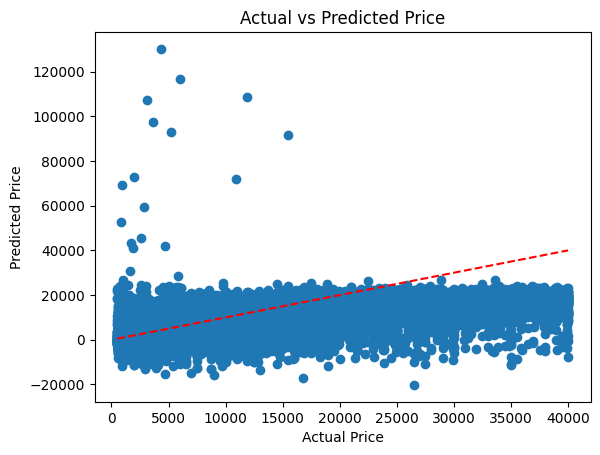

In [ ]:
import matplotlib.pyplot as plt
y_test=train_y
test_predictions=model.predict(train_X[variables])
plt.scatter(y_test, test_predictions, marker='o', alpha=1)

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

In [ ]:
# run a linear regression of Price on the remaining 10 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:12:02   Log-Likelihood:            -1.4375e+06
No. Observations:              145554   AIC:                         2.875e+06
Df Residuals:                  145540   BIC:                         2.875e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

abtest_test , num_interval_creation_firstseen and monthOfRegistration are not statistically significant as they have P value >0.05